In [11]:
import pandas as pd
import numpy as np

In [12]:
#read csv
df = pd.read_csv("./course_lead_scoring.csv")

In [13]:
columns = list(df.columns)
for col in columns:
    if df[col].dtype=='float64' or df[col].dtype=='int64':
        df[col]=df[col].fillna(0.0)
    else:
        df[col]=df[col].fillna('NA')

In [14]:
from sklearn.model_selection import train_test_split

In [15]:

df_full_train,df_test = train_test_split(df,test_size=0.2,random_state=1)
df_train,df_val = train_test_split(df_full_train,test_size=0.25,random_state=1)

In [6]:

df_full_train.reset_index(drop=True,inplace=True)
df_test.reset_index(drop=True,inplace=True)
df_train.reset_index(drop=True,inplace=True)
df_val.reset_index(drop=True,inplace=True)

In [7]:
y_full_train = df_full_train['converted']
y_test = df_test['converted']
y_train = df_train['converted']
y_val = df_val['converted']

del df_full_train['converted']
del df_test['converted']
del df_train['converted']
del df_val['converted']

In [8]:
y_train

0      0
1      1
2      0
3      0
4      0
      ..
871    1
872    1
873    0
874    0
875    0
Name: converted, Length: 876, dtype: int64

In [18]:
from sklearn.metrics import roc_auc_score

# Target variable
y_train = df_train['converted']

# Numerical features
numerical = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']

print("ROC AUC scores for each numerical variable:\n")

for col in numerical:
    score = df_train[col]
    auc = roc_auc_score(y_train, score)
    
    # If AUC < 0.5, invert the feature
    if auc < 0.5:
        auc = roc_auc_score(y_train, -score)
        direction = " (inverted)"
    else:
        direction = ""
    
    print(f"{col}: {auc:.3f}{direction}")


ROC AUC scores for each numerical variable:

lead_score: 0.614
number_of_courses_viewed: 0.764
interaction_count: 0.738
annual_income: 0.552


In [19]:
categorical = ['lead_source', 'industry', 'employment_status', 'location']
numerical = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']


In [20]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Separate features & target
X_train = df_train[categorical + numerical]
y_train = df_train['converted']

X_val = df_val[categorical + numerical]
y_val = df_val['converted']

# One-hot encoding
dv = DictVectorizer(sparse=False)
train_dicts = X_train.to_dict(orient='records')
val_dicts = X_val.to_dict(orient='records')

X_train_enc = dv.fit_transform(train_dicts)
X_val_enc = dv.transform(val_dicts)

# Train logistic regression
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_enc, y_train)

# Predict probabilities for validation set
y_pred = model.predict_proba(X_val_enc)[:, 1]

# Compute AUC
auc = roc_auc_score(y_val, y_pred)
print(f"Validation AUC: {auc:.3f}")


Validation AUC: 0.817


/home/purushothamad/anaconda3/envs/ml-zoomcamp/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/purushothamad/anaconda3/envs/ml-zoomcamp/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/purushothamad/anaconda3/envs/ml-zoomcamp/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

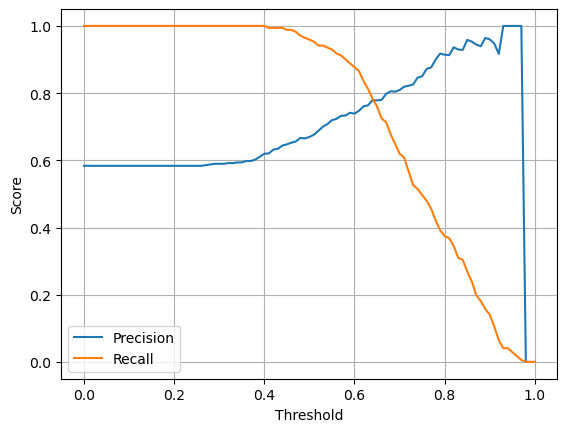

In [22]:
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt

thresholds = np.arange(0.0, 1.01, 0.01)
precisions = []
recalls = []

for t in thresholds:
    y_pred_bin = (y_pred >= t)
    precisions.append(precision_score(y_val, y_pred_bin))
    recalls.append(recall_score(y_val, y_pred_bin))

# Plot
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()


In [23]:
diff = np.abs(np.array(precisions) - np.array(recalls))
t_best = thresholds[diff.argmin()]
print(f"Precision and Recall intersect around threshold: {t_best:.3f}")


Precision and Recall intersect around threshold: 0.980


In [24]:

# Convert to numpy arrays for vectorized operations
precisions = np.array(precisions)
recalls = np.array(recalls)

# Compute F1 scores safely (avoid division by zero)
f1_scores = 2 * precisions * recalls / (precisions + recalls + 1e-10)

# Find threshold where F1 is maximum
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best threshold for F1: {best_threshold:.3f}, F1 = {best_f1:.3f}")


Best threshold for F1: 0.570, F1 = 0.812


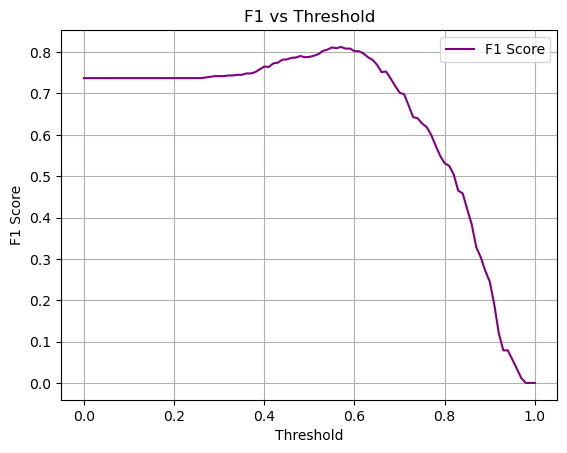

In [26]:


plt.plot(thresholds, f1_scores, label='F1 Score', color='purple')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 vs Threshold')
plt.grid(True)
plt.legend()
plt.show()


In [27]:
from sklearn.model_selection import KFold

In [28]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)


In [29]:
aucs = []

for train_idx, val_idx in kf.split(df_full_train):
    # Split data
    df_train_cv = df_full_train.iloc[train_idx]
    df_val_cv = df_full_train.iloc[val_idx]
    
    y_train_cv = df_train_cv['converted']
    y_val_cv = df_val_cv['converted']
    
    X_train_cv = df_train_cv[categorical + numerical]
    X_val_cv = df_val_cv[categorical + numerical]
    
    # One-hot encoding
    dv = DictVectorizer(sparse=False)
    X_train_enc = dv.fit_transform(X_train_cv.to_dict(orient='records'))
    X_val_enc = dv.transform(X_val_cv.to_dict(orient='records'))
    
    # Train logistic regression
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_enc, y_train_cv)
    
    # Predict & evaluate
    y_pred_cv = model.predict_proba(X_val_enc)[:, 1]
    auc = roc_auc_score(y_val_cv, y_pred_cv)
    aucs.append(auc)

# Compute standard deviation
std_auc = np.std(aucs)
print(f"AUCs across folds: {aucs}")
print(f"Standard deviation: {std_auc:.3f}")


AUCs across folds: [0.8060745924216483, 0.8713738368910783, 0.7754320118852139, 0.8018368617683685, 0.8558272713202291]
Standard deviation: 0.036


In [31]:
results = []
C_values = [0.000001, 0.001, 1]

for C in C_values:
    aucs = []
    
    for train_idx, val_idx in kf.split(df_full_train):
        df_train_cv = df_full_train.iloc[train_idx]
        df_val_cv = df_full_train.iloc[val_idx]
        
        y_train_cv = df_train_cv['converted']
        y_val_cv = df_val_cv['converted']
        
        X_train_cv = df_train_cv[categorical + numerical]
        X_val_cv = df_val_cv[categorical + numerical]
        
        dv = DictVectorizer(sparse=False)
        X_train_enc = dv.fit_transform(X_train_cv.to_dict(orient='records'))
        X_val_enc = dv.transform(X_val_cv.to_dict(orient='records'))
        
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train_enc, y_train_cv)
        
        y_pred_cv = model.predict_proba(X_val_enc)[:, 1]
        aucs.append(roc_auc_score(y_val_cv, y_pred_cv))
    
    mean_auc = round(np.mean(aucs), 3)
    std_auc = round(np.std(aucs), 3)
    results.append((C, mean_auc, std_auc))

# Display results
for C, mean_auc, std_auc in results:
    print(f"C={C}, Mean AUC={mean_auc}, Std={std_auc}")

# Find the best C
results.sort(key=lambda x: (-x[1], x[2], x[0]))  # max mean, then min std, then min C
best_C = results[0][0]
print(f"Best C: {best_C}")


C=1e-06, Mean AUC=0.56, Std=0.024
C=0.001, Mean AUC=0.867, Std=0.029
C=1, Mean AUC=0.822, Std=0.036
Best C: 0.001
